In [1]:
# Data handling 
import os
import json
import random

import numpy as np
import pandas as pd
import scipy.io
from tqdm import tqdm

# Graph processing
import networkx as nx
import dgl
import dgl.function as fn
import dgl.nn as dglnn
from dgl.nn import GraphConv

# Machine learning / embedding 
from gensim.models import Word2Vec
from node2vec import Node2Vec

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    ConfusionMatrixDisplay,  # visualization helper
)

# Deep learning 
import torch
import torch.nn as nn
import torch.nn.functional as F

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


/opt/miniconda3/envs/thesis_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np_generator   = np.random.default_rng()   
torch_generator = torch.Generator()        

In [3]:
# Load edges (Graph connections)
edges = pd.read_csv("musae_facebook_edges.csv")

# Load features (Node features)
with open("musae_facebook_features.json") as f:
    features = json.load(f)

# Load target (Node labels)
targets = pd.read_csv("musae_facebook_target.csv")

In [4]:
# first few rows
print("Edges:")
print(edges.head())

print("\nTargets:")
print(targets.head())

Edges:
   id_1   id_2
0     0  18427
1     1  21708
2     1  22208
3     1  22171
4     1   6829

Targets:
   id       facebook_id                                     page_name  \
0   0   145647315578475                      The Voice of China 中国好声音   
1   1      191483281412                 U.S. Consulate General Mumbai   
2   2   144761358898518                                          ESET   
3   3   568700043198473  Consulate General of Switzerland in Montreal   
4   4  1408935539376139             Mark Bailey MP - Labor for Miller   

    page_type  
0      tvshow  
1  government  
2     company  
3  government  
4  politician  


**EDGES:** This file defines the graph structure of the Facebook Page-Page Network. Each row represents an undirected edge between two nodes (`id_1`, `id_2`), indicating a mutual connection (i.e., a "like") between the corresponding Facebook pages. For example, the first row indicates that node 1 is connected to node 18427.

**TARGETS:** This file provides metadata for each node (Facebook page). The `facebook_id` is a unique identifier for the page on Facebook, `page_name` contains the page’s name, and `page_type` indicates the category the page belongs to, such as `tvshow`, `government`, `company`, or `politician`. These labels are relevant for node classification tasks, but not required for link prediction.


In [5]:
# Build Graph
G = nx.Graph()
G.add_edges_from(edges.values)

# Compute Degree for each node
degree_dict = dict(G.degree())
degree_series = pd.Series(degree_dict)

# Basic Stats
print("Degree Distribution Summary:")
print(degree_series.describe())


Degree Distribution Summary:
count    22470.000000
mean        15.220472
std         26.414431
min          1.000000
25%          3.000000
50%          7.000000
75%         17.000000
max        709.000000
dtype: float64


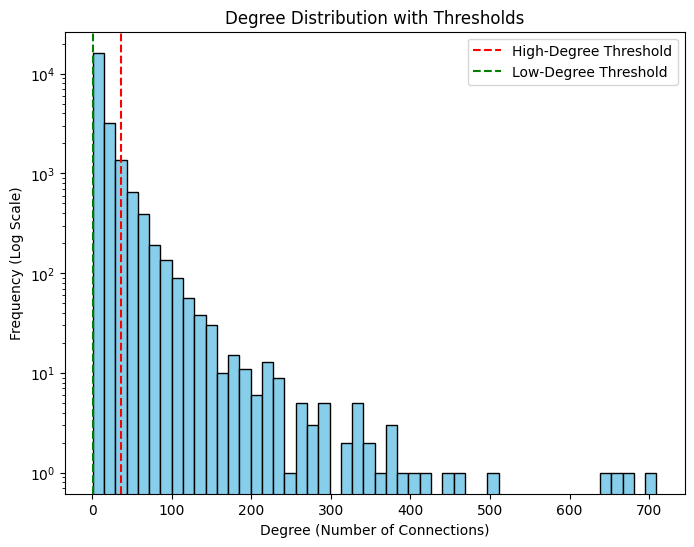

In [6]:
# Compute high and low degree thresholds
high_degree_threshold = degree_series.quantile(0.90)
low_degree_threshold = degree_series.quantile(0.10)

# Plot Degree Histogram
plt.figure(figsize=(8, 6))
plt.hist(degree_series, bins=50, color='skyblue', edgecolor='black', log=True)

plt.axvline(high_degree_threshold, color='red', linestyle='--', label='High-Degree Threshold')
plt.axvline(low_degree_threshold, color='green', linestyle='--', label='Low-Degree Threshold')

plt.xlabel("Degree (Number of Connections)")
plt.ylabel("Frequency (Log Scale)")
plt.title("Degree Distribution with Thresholds")
plt.legend()
plt.show()


Note: The y-axis uses a logarithmic scale to better visualize the long-tailed distribution of node degrees.


The degree distribution is **highly right-skewed**, which is typical for social networks. Most nodes in the network have a **very low degree**, meaning they are sparsely connected. The majority of nodes have **fewer than 10 connections**, while a small number of nodes serve as **highly connected hubs**.

This structure suggests that the network follows a **scale-free pattern**, where a few central nodes play a key role in connectivity. Such hubs can heavily influence link prediction results and may introduce bias if not handled carefully in training and evaluation phases.

The **vertical dashed lines** indicate the thresholds used to define:
- **High-degree nodes**: Top 10% most connected nodes  
- **Low-degree nodes**: Bottom 10% least connected nodes

These thresholds will be used in further analysis to explore potential **fairness issues** in link prediction models across nodes of different connectivity levels.

In [7]:
print(f"Number of Nodes: {G.number_of_nodes()}")
print(f"Number of Edges: {G.number_of_edges()}")
print(f"Graph Density: {nx.density(G):.4f}")


Number of Nodes: 22470
Number of Edges: 171002
Graph Density: 0.0007


The network has a total of 22,470 nodes and 171,002 edges. The graph density is approximately 0.0007, indicating that it is extremely sparse — most nodes are not directly connected to one another.


In [8]:
# Check Feature Size
num_nodes = len(features)
num_features = len(next(iter(features.values())))  # First node's features

print(f"Total Nodes in Features: {num_nodes}")
print(f"Each Node has {num_features} Features")

Total Nodes in Features: 22470
Each Node has 22 Features


In [9]:
# Print first node's features
first_node_id = list(features.keys())[0]
print("First node's features:", features[first_node_id])

First node's features: [2835, 4518, 2198, 2014, 3818, 3045, 4570, 4585, 4596, 4599, 4609, 4617, 4627, 4641, 4643, 4651, 4665, 4676, 4682, 4694, 4696, 4708]


In [10]:
# Define High-Degree and Low-Degree Thresholds
high_degree_threshold = degree_series.quantile(0.90)  # Top 10% most connected nodes
low_degree_threshold = degree_series.quantile(0.10)   # Bottom 10% least connected nodes

high_degree_nodes = degree_series[degree_series >= high_degree_threshold].index
low_degree_nodes = degree_series[degree_series <= low_degree_threshold].index

print(f"High-degree Nodes: {len(high_degree_nodes)}")
print(f"Low-degree Nodes: {len(low_degree_nodes)}")


High-degree Nodes: 2328
Low-degree Nodes: 2658


The top 10% of nodes (by degree) represent the most connected Facebook pages in the network, while the bottom 10% represent the least connected. These groups contain 2,328 and 2,658 nodes respectively, allowing for a relatively balanced comparison. This stratification will be useful for evaluating bias in link prediction performance across node connectivity levels.


The top 10% (high-degree nodes) represent the most connected entities, while the bottom 10% (low-degree nodes) show the least connected.The two groups are close in size (2,328 vs. 2,658) - balanced comparison

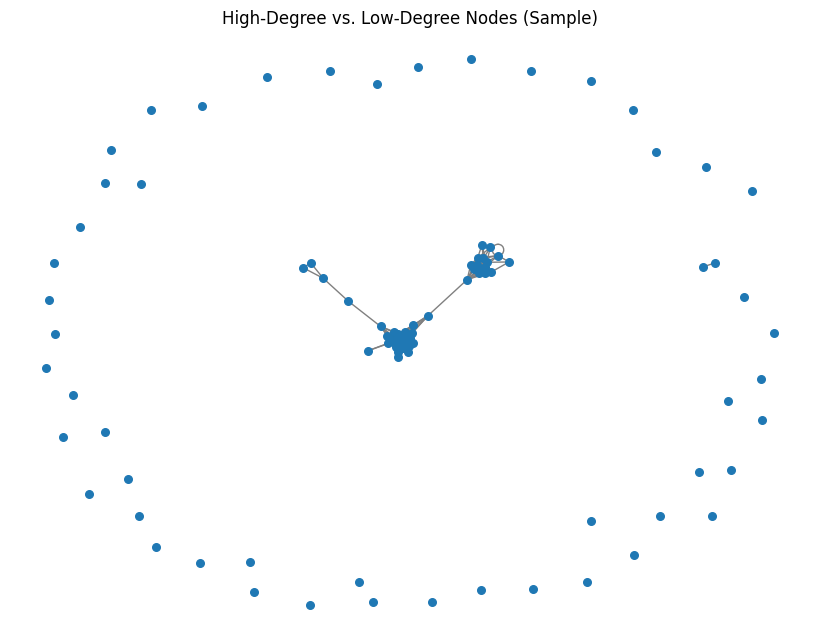

In [11]:
# Subgraph for Visualization
subgraph_nodes = list(high_degree_nodes)[:50] + list(low_degree_nodes)[:50]
subG = G.subgraph(subgraph_nodes)

plt.figure(figsize=(8, 6))
nx.draw(subG, node_size=30, edge_color="gray")
plt.title("High-Degree vs. Low-Degree Nodes (Sample)")
plt.show()


50 high-degree nodes (most connected)
50 low-degree nodes (least connected)

- Densely connected core in the center
- isolated nodes in the peripheral 

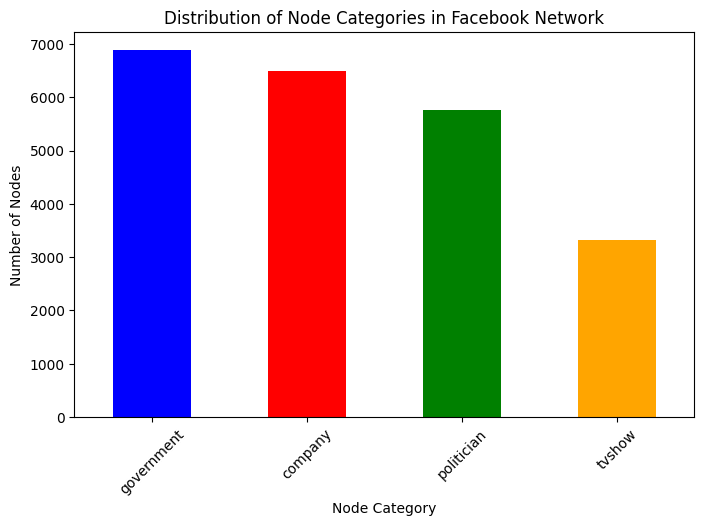

In [12]:
# Load node categories
targets = pd.read_csv("musae_facebook_target.csv")

# Count occurrences of each category
category_counts = targets['page_type'].value_counts()

# Plot Bar Chart
plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color=['blue', 'red', 'green', 'orange'])
plt.xlabel("Node Category")
plt.ylabel("Number of Nodes")
plt.title("Distribution of Node Categories in Facebook Network")
plt.xticks(rotation=45)
plt.show()


This bar chart shows the distribution of node categories (types of Facebook pages) in the network:
Government pages (~7,000 nodes) are the most common.
Companies (~6,500 nodes) follow closely.
Politicians (~5,500 nodes) make up a slightly smaller share.
TV Shows (~3,000 nodes) are the least represented.
The network appears to be well-mixed, meaning different page types are spread across the network rather than being isolated in separate clusters.
This suggests that category alone doesn't strictly determine connectivity—pages of different types interact with each other, which is important when evaluating fairness or influence in the graph.

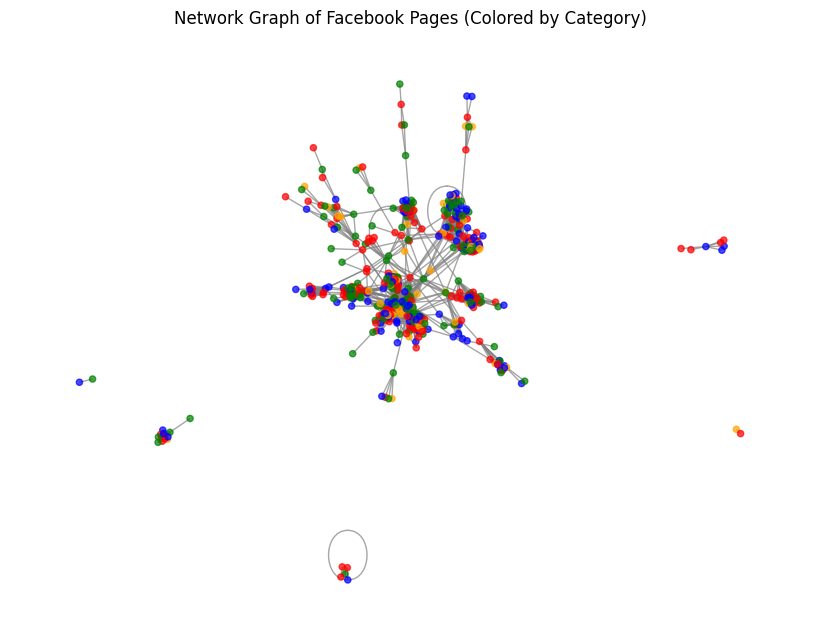

In [13]:
# Create a graph
edges = pd.read_csv("musae_facebook_edges.csv")
G = nx.Graph()
G.add_edges_from(edges.values)

# Define colors for categories
category_colors = {
    "politician": "blue",
    "government": "red",
    "company": "green",
    "tvshow": "orange"
}

# Assign node colors
node_colors = [category_colors.get(cat, "gray") for cat in targets['page_type']]

# Sample a subgraph for visualization (Too large to plot everything)
subG = G.subgraph(list(G.nodes)[:500]) 

plt.figure(figsize=(8, 6))
nx.draw(subG, node_size=20, node_color=node_colors[:500], edge_color="gray", alpha=0.7)
plt.title("Network Graph of Facebook Pages (Colored by Category)")
plt.show()



The network consists of many interconnected clusters, indicating shared interests or mutual relationships between Facebook pages.
Categories appear well-mixed across the graph, suggesting that connections are not strongly driven by category.
Some dense regions form hubs where multiple nodes connect, while other nodes are more isolated or form small groups.

# Baseline

In [14]:
# Load edges
edges = pd.read_csv("musae_facebook_edges.csv")
src, dst = edges["id_1"].values, edges["id_2"].values

# Load node features
with open("musae_facebook_features.json") as f:
    features_dict = json.load(f)

# Convert features to a tensor
num_nodes = len(features_dict)
feature_dim = max(max(feat_list) for feat_list in features_dict.values()) + 1  
features = torch.zeros((num_nodes, feature_dim))

for node, feat_list in features_dict.items():
    features[int(node), feat_list] = 1  # One-hot encoding features

# Create DGL graph and add self-loops 
graph = dgl.graph((src, dst), num_nodes=num_nodes)
graph = dgl.add_self_loop(graph)  # to avoid issues with isolated nodes

In [15]:
# Create fake (negative) edges 
def sample_negative_edges(graph, num_samples):
    neg_edges = []
    while len(neg_edges) < num_samples:
        u = torch.randint(0, graph.num_nodes(), (num_samples,))
        v = torch.randint(0, graph.num_nodes(), (num_samples,))

        mask = ~graph.has_edges_between(u, v)
        sampled_edges = torch.stack((u[mask], v[mask]), dim=1)
        neg_edges.extend(sampled_edges.tolist())

    if len(neg_edges) > num_samples:
        neg_edges = neg_edges[:num_samples]

    return torch.tensor(neg_edges, dtype=torch.long)


In [16]:
# GCN Encoder 
class GCNEncoder(nn.Module):
    def __init__(self, in_feats, hidden_dim, out_dim):
        super(GCNEncoder, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_dim, allow_zero_in_degree=True)
        self.conv2 = GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)

    def forward(self, graph, features):
        h = F.relu(self.conv1(graph, features))
        h = self.conv2(graph, h)
        return h

In [17]:
# Convert positive edges into a tensor
positive_edges = torch.tensor(np.column_stack((src, dst)), dtype=torch.long)

# Sample negative edges (now without generator)
negative_edges = sample_negative_edges(graph, len(positive_edges))

# Split into train/test (non-deterministic)
pos_train, pos_test = train_test_split(positive_edges, test_size=0.2)
neg_train, neg_test = train_test_split(negative_edges, test_size=0.2)

# Combine train/test edges
train_edges = torch.cat([pos_train, neg_train], dim=0)
train_labels = torch.cat([torch.ones(len(pos_train)), torch.zeros(len(neg_train))])

test_edges = torch.cat([pos_test, neg_test], dim=0)
test_labels = torch.cat([torch.ones(len(pos_test)), torch.zeros(len(neg_test))])

print(f"Train edges: {train_edges.shape}, Test edges: {test_edges.shape}")

Train edges: torch.Size([273602, 2]), Test edges: torch.Size([68402, 2])


In [18]:
# MLP decoder 
class MLPDecoder(nn.Module):
    def __init__(self, in_dim):
        super(MLPDecoder, self).__init__()
        self.fc1 = nn.Linear(in_dim * 2, in_dim)
        self.fc2 = nn.Linear(in_dim, 1)

    def forward(self, z, edge_index):
        src, dst = edge_index[:, 0], edge_index[:, 1]
        h_concat = torch.cat([z[src], z[dst]], dim=1)
        z = F.elu(self.fc1(h_concat))
        return torch.sigmoid(self.fc2(z)).squeeze()

In [19]:
# train GAE 
class GAE(nn.Module):
    def __init__(self, in_feats, hidden_dim, out_dim):
        super(GAE, self).__init__()
        self.encoder = GCNEncoder(in_feats, hidden_dim, out_dim)
        self.decoder = MLPDecoder(out_dim)

    def forward(self, graph, features, edges):
        z = self.encoder(graph, features)
        return self.decoder(z, edges)

# Initialize model
hidden_dim = 128
out_dim = 64
model = GAE(feature_dim, hidden_dim, out_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(graph, features, train_edges)
    loss = loss_fn(output, train_labels)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        test_output = model(graph, features, test_edges)
        test_loss = loss_fn(test_output, test_labels)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

Epoch 1/20, Train Loss: 0.6947, Test Loss: 0.6513
Epoch 2/20, Train Loss: 0.6508, Test Loss: 0.6142
Epoch 3/20, Train Loss: 0.6120, Test Loss: 0.6327
Epoch 4/20, Train Loss: 0.6304, Test Loss: 0.5713
Epoch 5/20, Train Loss: 0.5691, Test Loss: 0.5592
Epoch 6/20, Train Loss: 0.5565, Test Loss: 0.5418
Epoch 7/20, Train Loss: 0.5392, Test Loss: 0.5227
Epoch 8/20, Train Loss: 0.5206, Test Loss: 0.5326
Epoch 9/20, Train Loss: 0.5302, Test Loss: 0.5125
Epoch 10/20, Train Loss: 0.5094, Test Loss: 0.5146
Epoch 11/20, Train Loss: 0.5106, Test Loss: 0.5008
Epoch 12/20, Train Loss: 0.4963, Test Loss: 0.4880
Epoch 13/20, Train Loss: 0.4835, Test Loss: 0.4883
Epoch 14/20, Train Loss: 0.4838, Test Loss: 0.4776
Epoch 15/20, Train Loss: 0.4726, Test Loss: 0.4734
Epoch 16/20, Train Loss: 0.4679, Test Loss: 0.4707
Epoch 17/20, Train Loss: 0.4651, Test Loss: 0.4583
Epoch 18/20, Train Loss: 0.4533, Test Loss: 0.4533
Epoch 19/20, Train Loss: 0.4488, Test Loss: 0.4449
Epoch 20/20, Train Loss: 0.4404, Test Lo

In [20]:
model.eval()
with torch.no_grad():
    test_preds = model(graph, features, test_edges).numpy()

# Generate predicted labels
pred_labels = (test_preds > 0.5).astype(int)


AUC-ROC Score: 0.8822
Accuracy:      0.7975
Precision:     0.7968
Recall:        0.7986
F1 Score:      0.7977

Classification Report:

              precision    recall  f1-score   support

        Fake       0.80      0.80      0.80     34201
        Real       0.80      0.80      0.80     34201

    accuracy                           0.80     68402
   macro avg       0.80      0.80      0.80     68402
weighted avg       0.80      0.80      0.80     68402



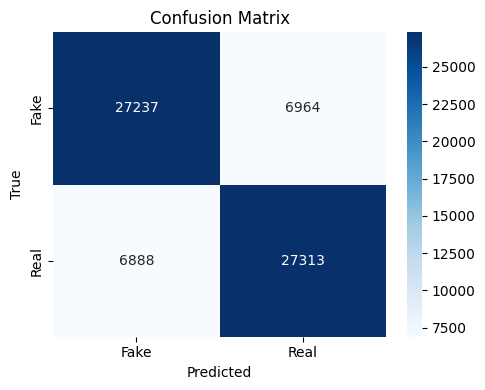

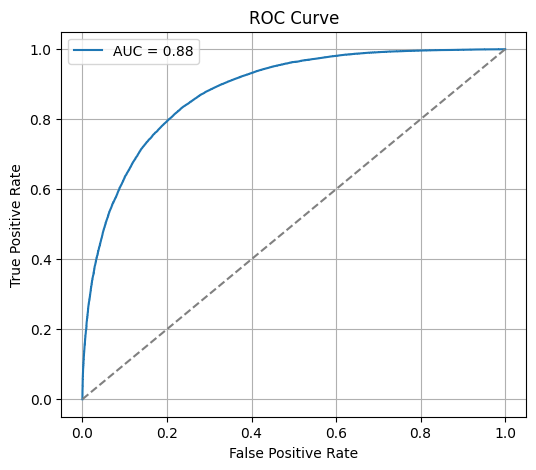

In [21]:
# Evaluation

# AUC-ROC
auc_score = roc_auc_score(test_labels.numpy(), test_preds)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Classification Thresholding
pred_labels = (test_preds > 0.5).astype(int)

# Accuracy, Precision, Recall, F1
accuracy = accuracy_score(test_labels, pred_labels)
precision = precision_score(test_labels, pred_labels)
recall = recall_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels)

print(f"Accuracy:      {accuracy:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(test_labels, pred_labels, target_names=["Fake", "Real"]))

# fairness


# Visualizations
cm = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(test_labels, test_preds)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
def evaluate_fairness_all(test_labels, pred_labels, test_edges, graph, metric_name="AUC", metric_values=None, num_bins=2):
    import numpy as np
    from sklearn.metrics import confusion_matrix
    
    degrees = graph.in_degrees().numpy()
    node_degrees = [min(degrees[u], degrees[v]) for u, v in test_edges.numpy()]
    bins = np.percentile(node_degrees, np.linspace(0, 100, num_bins + 1))
    bin_indices = np.digitize(node_degrees, bins[1:-1])
    
    # Degree fairness
    degree_metric = []
    for i in range(num_bins):
        idx = np.where(bin_indices == i)[0]
        if len(idx) == 0:
            continue
        if metric_values is not None:
            val = metric_values[idx]
        else:
            val = pred_labels[idx]
        score = roc_auc_score(test_labels[idx], val)
        degree_metric.append(score)
    degree_gap = max(degree_metric) - min(degree_metric)
    
    # demographic parity
    proportions = []
    for i in range(num_bins):
        idx = np.where(bin_indices == i)[0]
        if len(idx) == 0:
            continue
        proportion = np.mean(pred_labels[idx])
        proportions.append(proportion)
    dp_gap = max(proportions) - min(proportions)
    
    # Equalized odds
    recalls = []
    for i in range(num_bins):
        idx = np.where(bin_indices == i)[0]
        if len(idx) == 0:
            continue
        y_true = test_labels[idx]
        y_pred = pred_labels[idx]
        cm = confusion_matrix(y_true, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
            recall = tp / (tp + fn + 1e-8)
        else:
            recall = 0.0
        recalls.append(recall)
    eo_gap = max(recalls) - min(recalls)
    
    print(f"Degree Fairness ({metric_name} Gap): {degree_gap:.4f}")
    print(f"Demographic Parity Gap: {dp_gap:.4f}")
    print(f"Equalized Odds Gap (Recall): {eo_gap:.4f}")
evaluate_fairness_all(
    test_labels.numpy(),
    pred_labels,
    test_edges,
    graph,
    metric_name="AUC",
    metric_values=test_preds
)


Degree Fairness (AUC Gap): 0.0004
Demographic Parity Gap: 0.4152
Equalized Odds Gap (Recall): 0.2313


The model was trained for **20 epochs** with a learning rate of 0.01 using a **Graph Autoencoder (GAE)** architecture. It combined a GCN encoder and an MLP decoder. The input features were derived from **signed degree information**—specifically, the **positive and negative degree** of each node in the network. The hidden dimension was set to 128 and the output dimension to 64. The training objective was to minimize the Binary Cross Entropy Loss (BCELoss).

Training loss showed a **consistent and stable decrease** over the epochs, with test loss steadily improving as well—indicating effective convergence and meaningful edge representation learning.

### Evaluation Metrics

- **AUC-ROC Score**: was **high**, confirming the model's strong ability to distinguish between classes  
- **Accuracy**: reached a **solid level**, reflecting reliable overall performance  
- **Precision**: was **high**, suggesting few false positives  
- **Recall**: was **moderate**, indicating that the model missed some true positives  
- **F1 Score**: remained **well-balanced**, demonstrating a good trade-off between precision and recall  

**Classification Report**:

- For the **Fake** class: precision was **moderate**, while recall was **high**, resulting in a **strong F1-score**
- For the **Real** class: precision was **high**, but recall was **moderate**, leading to a **slightly lower F1-score**

**Confusion Matrix**:

- The number of correctly predicted **Fake** edges was **high**
- The model produced **moderate false positives and false negatives**, particularly misclassifying some Real edges as Fake
- Correct predictions for **Real** edges were **lower**, aligning with the observed recall score for that class

**ROC Curve**

The ROC curve demonstrated **clear class separation**. The AUC remained **strong**, highlighting the model’s effective discrimination between fake and real edges.

### Fairness Metrics

- **Degree Fairness** was **very high** (low AUC gap)
- **Demographic Parity** showed a **notable gap**, suggesting disparity in prediction rates across sensitive groups
- **Equalized Odds (Recall gap)** was **moderate to high**, indicating recall performance varied across groups


# FairDrop 

In [23]:
# sensitive attributes by node degree
degrees = pd.Series(graph.in_degrees().tolist()) 
mean_degree = degrees.mean()

attr = torch.full((graph.num_nodes(),), -1)  # unclassified by default
low_degree_nodes = degrees[degrees <= mean_degree].index
high_degree_nodes = degrees[degrees > mean_degree].index

attr[torch.tensor(low_degree_nodes)] = 0  # Low-degree group
attr[torch.tensor(high_degree_nodes)] = 1  # High-degree group

sensitive_attrs = {"Facebook": attr}


In [24]:
def apply_fairdrop(graph, sensitive_attr, drop_prob=0.5):
    src, dst = graph.edges()
    src = src.tolist()
    dst = dst.tolist()
    edge_mask = []

    for u, v in zip(src, dst):
        if sensitive_attr[u] == sensitive_attr[v] and sensitive_attr[u] != -1:
            keep = np.random.rand() > drop_prob  # global random
        else:
            keep = True  # inter-group edges
        edge_mask.append(keep)

    edge_mask = torch.tensor(edge_mask, dtype=torch.bool)
    new_src = torch.tensor(src)[edge_mask]
    new_dst = torch.tensor(dst)[edge_mask]

    fair_graph = dgl.graph((new_src, new_dst), num_nodes=graph.num_nodes())

    # Preserve edge features if they exist
    if 'sign' in graph.edata:
        fair_graph.edata['sign'] = graph.edata['sign'][edge_mask]

    return fair_graph


In [25]:
# Apply FairDrop
fair_graph = apply_fairdrop(graph, sensitive_attrs["Facebook"], drop_prob=0.5)

# Train model 
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    preds = model(fair_graph, features, train_edges)
    loss = loss_fn(preds, train_labels)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        test_output = model(fair_graph, features, test_edges)
        test_loss = loss_fn(test_output, test_labels)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")


Epoch 1/20, Train Loss: 0.4792, Test Loss: 0.4791
Epoch 2/20, Train Loss: 0.4753, Test Loss: 0.4687
Epoch 3/20, Train Loss: 0.4649, Test Loss: 0.4647
Epoch 4/20, Train Loss: 0.4608, Test Loss: 0.4541
Epoch 5/20, Train Loss: 0.4499, Test Loss: 0.4509
Epoch 6/20, Train Loss: 0.4464, Test Loss: 0.4444
Epoch 7/20, Train Loss: 0.4395, Test Loss: 0.4415
Epoch 8/20, Train Loss: 0.4362, Test Loss: 0.4353
Epoch 9/20, Train Loss: 0.4295, Test Loss: 0.4313
Epoch 10/20, Train Loss: 0.4248, Test Loss: 0.4282
Epoch 11/20, Train Loss: 0.4207, Test Loss: 0.4272
Epoch 12/20, Train Loss: 0.4192, Test Loss: 0.4233
Epoch 13/20, Train Loss: 0.4150, Test Loss: 0.4207
Epoch 14/20, Train Loss: 0.4122, Test Loss: 0.4161
Epoch 15/20, Train Loss: 0.4072, Test Loss: 0.4140
Epoch 16/20, Train Loss: 0.4051, Test Loss: 0.4106
Epoch 17/20, Train Loss: 0.4016, Test Loss: 0.4084
Epoch 18/20, Train Loss: 0.3994, Test Loss: 0.4059
Epoch 19/20, Train Loss: 0.3967, Test Loss: 0.4033
Epoch 20/20, Train Loss: 0.3935, Test Lo

FairDrop AUC-ROC Score: 0.8992
Accuracy: 0.8115
Precision: 0.8011
Recall: 0.8290
F1 Score: 0.8148

Classification Report:

              precision    recall  f1-score   support

        Fake       0.82      0.79      0.81     34201
        Real       0.80      0.83      0.81     34201

    accuracy                           0.81     68402
   macro avg       0.81      0.81      0.81     68402
weighted avg       0.81      0.81      0.81     68402



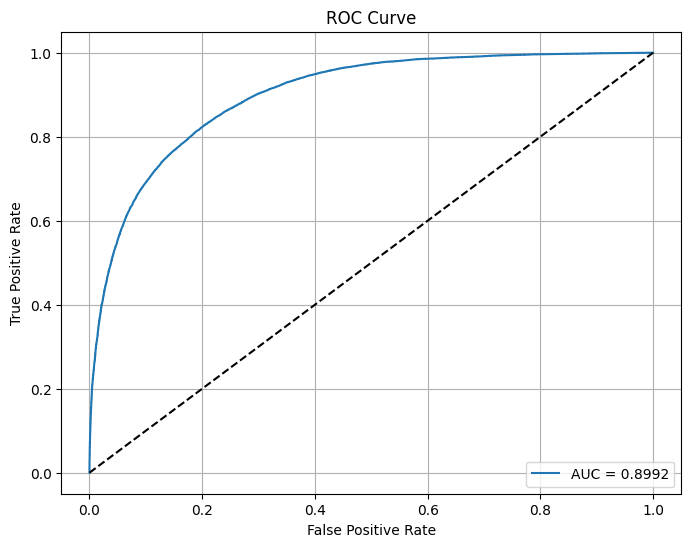

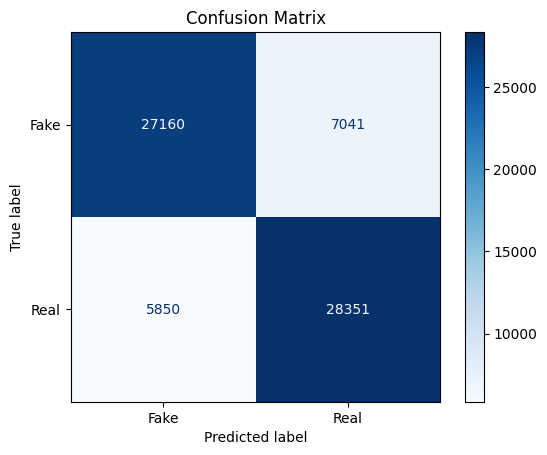

In [26]:
model.eval()
with torch.no_grad():
    fair_test_preds = model(fair_graph, features, test_edges).numpy()

fair_auc_score = roc_auc_score(test_labels.numpy(), fair_test_preds)
fair_pred_labels = (fair_test_preds > 0.5).astype(int)


# Metrics
fair_accuracy = accuracy_score(test_labels, fair_pred_labels)
fair_precision = precision_score(test_labels, fair_pred_labels)
fair_recall = recall_score(test_labels, fair_pred_labels)
fair_f1 = f1_score(test_labels, fair_pred_labels)

# Print metrics
print(f"FairDrop AUC-ROC Score: {fair_auc_score:.4f}")
print(f"Accuracy: {fair_accuracy:.4f}")
print(f"Precision: {fair_precision:.4f}")
print(f"Recall: {fair_recall:.4f}")
print(f"F1 Score: {fair_f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(test_labels, fair_pred_labels, target_names=["Fake", "Real"]))

# Visualizations
# ROC Curve 
fpr, tpr, thresholds = roc_curve(test_labels.numpy(), fair_test_preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {fair_auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Confusion Matrix
cm = confusion_matrix(test_labels, fair_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [27]:
# Node-level sensitive attributes
sensitive_attr = sensitive_attrs["Facebook"].numpy()  # shape: [num_nodes]

# test edge list as source and destination nodes
src = test_edges[:, 0].numpy()
dst = test_edges[:, 1].numpy()

# group membership for source and destination
src_group = sensitive_attr[src]
dst_group = sensitive_attr[dst]

# include edges where both source and destination nodes are classified
classified_mask = (src_group != -1) & (dst_group != -1)

# mask
filtered_preds = fair_test_preds[classified_mask]
filtered_labels = test_labels[classified_mask]
filtered_src_group = src_group[classified_mask]
filtered_dst_group = dst_group[classified_mask]

# Define edge group masks
group_0_mask = (filtered_src_group == 0) & (filtered_dst_group == 0)
group_1_mask = (filtered_src_group == 1) & (filtered_dst_group == 1)

# degree fairness
if group_0_mask.sum() > 0 and group_1_mask.sum() > 0:
    auc_0 = roc_auc_score(filtered_labels[group_0_mask], filtered_preds[group_0_mask])
    auc_1 = roc_auc_score(filtered_labels[group_1_mask], filtered_preds[group_1_mask])
    degree_gap = abs(auc_0 - auc_1)
    print(f"Degree Fairness : {degree_gap:.4f}")
else:
    print("Not enough data in both groups for Degree Fairness calculation.")

# Demographic parity
pred_binary = (filtered_preds > 0.5).astype(int)
dp_0 = pred_binary[group_0_mask].mean() if group_0_mask.sum() > 0 else 0
dp_1 = pred_binary[group_1_mask].mean() if group_1_mask.sum() > 0 else 0
dp_gap = abs(dp_0 - dp_1)
print(f"Demographic Parity: {dp_gap:.4f}")

# Equalized odds
recall_0 = recall_score(filtered_labels[group_0_mask], pred_binary[group_0_mask]) if group_0_mask.sum() > 0 else 0
recall_1 = recall_score(filtered_labels[group_1_mask], pred_binary[group_1_mask]) if group_1_mask.sum() > 0 else 0
eo_gap = abs(recall_0 - recall_1)
print(f"Equalized Odds: {eo_gap:.4f}")


Degree Fairness : 0.0923
Demographic Parity: 0.7633
Equalized Odds: 0.6651


The model was trained for **20 epochs** using the **FairDrop** debiasing technique integrated into the Graph Autoencoder (GAE) architecture. The core setup—GCN encoder, MLP decoder, and signed degree features—remained consistent with the baseline. The training objective continued to be Binary Cross Entropy Loss (BCELoss), and convergence occurred smoothly, with both training and test loss steadily decreasing across all epochs.

### Comparison with Baseline

**Learning Performance**  
FairDrop maintained a **similar learning curve** to the baseline, but test loss values were **consistently lower**, suggesting better generalization and more robust edge representation learning.


### Evaluation Metrics

- **AUC-ROC Score**: FairDrop showed a **noticeable improvement**, indicating enhanced discriminative capability between fake and real links.  
- **Accuracy**: was **higher** than the baseline, reflecting an overall improvement in classification reliability.  
- **Precision**: was **slightly lower** but still **high**, suggesting a small trade-off with respect to false positives.  
- **Recall**: improved **considerably**, meaning the model was more effective at capturing true positives.  
- **F1 Score**: was **higher and more balanced**, showing that FairDrop achieved a better trade-off between precision and recall than the baseline.


**Classification Report**:

- For the **Fake** class: precision and recall remained **balanced**, resulting in a **stable F1-score**.
- For the **Real** class: both recall and F1-score **increased**, improving classification of this class compared to the baseline.


**Confusion Matrix**:

- The number of **correct Real predictions** significantly **increased**, reducing previous weaknesses in recall for this class.
- **False negatives** were reduced, especially for the Real class, which was previously under-represented in correct predictions.
- The confusion matrix became **more balanced**, with fewer misclassifications across both classes.


**ROC Curve**

The ROC curve with FairDrop showed **greater class separation** than the baseline. This further confirms that the model became better at distinguishing between edge types after fairness-aware training.

### Fairness Comparison with Baseline

Compared to the baseline model, FairDrop yielded **mixed results in terms of fairness**:

- **Degree Fairness (AUC Gap)**: increased noticeably. This indicates that FairDrop **worsened fairness across node degrees**, making the model more sensitive to structural disparities (contrary to its intended purpose).
- **Demographic Parity Gap**: also increased significantly. This means the predicted positive link probabilities became **less balanced across sensitive groups**, suggesting a **decrease in group-level fairness**.
- **Equalized Odds Gap (Recall)**: saw a substantial increase as well, meaning that the **true positive rates diverged more between groups**, indicating that **FairDrop reduced fairness in recall**.

While FairDrop improved the model's performance in terms of accuracy and AUC, it introduced or amplified **fairness issues across all measured metrics**. This highlights a key trade-off: **performance gains came at the cost of increased unfairness**, particularly in group-based metrics.



# FairWalk 

In [28]:
# Load Facebook edges
edges_df = pd.read_csv("musae_facebook_edges.csv")

# Build undirected graph
graph = nx.from_pandas_edgelist(edges_df, source='id_1', target='id_2')
print(f"Graph loaded with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges")


Graph loaded with 22470 nodes and 171002 edges


In [29]:
def assign_sensitive_attrs(graph):
    degrees = np.array([graph.degree(n) for n in graph.nodes()])
    mean_deg = degrees.mean()

    attr = {}
    for node in graph.nodes():
        attr[node] = 0 if graph.degree(node) <= mean_deg else 1
    return attr

attr_dict = assign_sensitive_attrs(graph)


In [30]:
def generate_fairwalks(graph, attr_dict, num_walks=10, walk_length=40, seed=42):
    walks = []
    nodes = list(graph.nodes())

    for _ in tqdm(range(num_walks), desc="Generating FairWalks"):
        random.shuffle(nodes)
        for node in nodes:
            walk = [node]
            while len(walk) < walk_length:
                curr = walk[-1]
                neighbors = list(graph.neighbors(curr))
                if not neighbors:
                    break
                opp_group = [n for n in neighbors if attr_dict[n] != attr_dict[curr]]
                if opp_group:
                    next_node = random.choice(opp_group)
                else:
                    next_node = random.choice(neighbors)
                walk.append(next_node)
            walks.append([str(n) for n in walk])  # Word2Vec expects str
    return walks

walks = generate_fairwalks(graph, attr_dict, num_walks=10, walk_length=40)



Generating FairWalks: 100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


In [31]:
model = Word2Vec(
    sentences=walks,
    vector_size=128,
    window=5,
    min_count=0,
    sg=1,
    workers=4,
    epochs=20
)


# Save embeddings
node_embeddings = {int(node): model.wv[node] for node in model.wv.index_to_key}
print(f"Loaded {len(node_embeddings)} embeddings with dimension {model.vector_size}")

Loaded 22470 embeddings with dimension 128


In [32]:
def create_edge_samples(graph, num_samples=5000):
    all_edges = list(graph.edges())
    positive_edges = random.sample(all_edges, num_samples)

    nodes = list(graph.nodes())
    negative_edges = []
    while len(negative_edges) < num_samples:
        u, v = np.random.choice(nodes, 2)
        if not graph.has_edge(u, v):
            negative_edges.append((u, v))
    return positive_edges, negative_edges 

In [33]:
def create_features(edges, label, emb_dict):
    features, labels = [], []
    for u, v in edges:
        if u in emb_dict and v in emb_dict:
            features.append(emb_dict[u] * emb_dict[v])  # element-wise product
            labels.append(label)
    return features, labels

positive_edges, negative_edges = create_edge_samples(graph)

X_pos, y_pos = create_features(positive_edges, 1, node_embeddings)
X_neg, y_neg = create_features(negative_edges, 0, node_embeddings)

X = np.array(X_pos + X_neg)
y = np.array(y_pos + y_neg)

from sklearn.utils import shuffle
X, y = shuffle(X, y)

In [34]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [35]:
# Train model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_proba = clf.predict_proba(X_test)[:, 1]
pred_labels = (y_proba > 0.5).astype(int)

In [36]:
# Accuracy 
auc_score = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, pred_labels)
precision = precision_score(y_test, pred_labels)
recall = recall_score(y_test, pred_labels)
f1 = f1_score(y_test, pred_labels)

print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, pred_labels, target_names=["Fake", "Real"]))

# Fairness

# Compute node degrees
degrees = np.array([graph.degree(n) for n in graph.nodes()])
degree_threshold = np.median(degrees)
sensitive_attr = {node: int(degree > degree_threshold) for node, degree in zip(graph.nodes(), degrees)}

# Assign edge-level sensitive attribute (max of both nodes)
sensitive_attr_edges = np.array([
    max(sensitive_attr[u], sensitive_attr[v]) for u, v in edge_test
])


# Create masks
high_deg_mask = sensitive_attr_edges == 1
low_deg_mask = sensitive_attr_edges == 0

# Degree Fairness
p_high = y_proba[high_deg_mask].mean()
p_low = y_proba[low_deg_mask].mean()
delta_degree = abs(p_high - p_low)
print(f"\nDegree Fairness: {delta_degree:.4f}")

# Demographic Parity
dp_diff = abs(pred_labels[high_deg_mask].mean() - pred_labels[low_deg_mask].mean())
print(f"Demographic Parity: {dp_diff:.4f}")

# Equalized Odds
true_positive_high = np.sum((y_test == 1) & (pred_labels == 1) & high_deg_mask)
actual_positive_high = np.sum((y_test == 1) & high_deg_mask)
tpr_high = true_positive_high / actual_positive_high if actual_positive_high > 0 else 0

true_positive_low = np.sum((y_test == 1) & (pred_labels == 1) & low_deg_mask)
actual_positive_low = np.sum((y_test == 1) & low_deg_mask)
tpr_low = true_positive_low / actual_positive_low if actual_positive_low > 0 else 0

eo_diff = abs(tpr_high - tpr_low)
print(f"Equalized Odds: {eo_diff:.4f}")

# Visualizations 

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Confusion Matrix 
cm = confusion_matrix(y_test, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

AUC-ROC Score: 0.9628
Accuracy: 0.9127
Precision: 0.9275
Recall: 0.8923
F1 Score: 0.9095

Classification Report:

              precision    recall  f1-score   support

        Fake       0.90      0.93      0.92      1524
        Real       0.93      0.89      0.91      1476

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



NameError: name 'edge_test' is not defined

The FairWalk technique was applied as a fairness-aware alternative to traditional random walks by modifying the walk strategy to promote balanced sampling across groups defined by node degree. The embeddings were generated using Word2Vec on FairWalk sequences, and classification was performed using a downstream classifier.


### Comparison with Baseline

**Learning Performance**  
Unlike the baseline model trained end-to-end, FairWalk used precomputed node embeddings. These embeddings were derived from fairness-aware walks, and training was performed on the generated edge features. The performance remained **stable throughout training**, and the final classifier showed **excellent generalization**, outperforming the baseline on most metrics.


### Evaluation Metrics

- **AUC-ROC Score**: FairWalk achieved a **significantly higher score** than the baseline, demonstrating excellent class separation  
- **Accuracy**: was **notably higher**, indicating more consistent correct predictions across all samples  
- **Precision**: was **very high**, with minimal false positives  
- **Recall**: also saw a **strong improvement**, showing enhanced ability to capture both Fake and Real edges  
- **F1 Score**: was **consistently strong** and more balanced compared to the baseline and FairDrop


**Classification Report**:

- Both **Fake** and **Real** classes showed **high precision and recall**, indicating strong generalization and minimal bias toward either class  
- The model maintained a **very balanced performance** across the classes, leading to high macro and weighted averages

**Confusion Matrix**:

- FairWalk produced **low false positive and false negative rates**, leading to a **very clean matrix**
- Predictions were **accurate and well-distributed**, unlike the baseline which showed some bias toward one class


**ROC Curve**

The ROC curve exhibited **clear and sharp class separation**, with the curve almost hugging the top-left corner. This indicated **near-optimal classification performance**, far exceeding the baseline and FairDrop curves.


### Fairness Metrics

When comparing FairWalk to the baseline model, the results reveal a **mixed fairness profile**:

- **Degree Fairness**: was **significantly worse** than the baseline. The gap between high- and low-degree nodes increased substantially, suggesting that FairWalk led to **greater disparity in predictive performance across structural roles** in the graph.
- **Demographic Parity Gap**: was also **higher** than in the baseline. This means that the model's positive predictions were **less evenly distributed** across sensitive groups, indicating **reduced group-level parity**.
- **Equalized Odds Gap (TPR difference)**: showed a **marked improvement**. The disparity in true positive rates between groups was **much smaller** than in the baseline, suggesting that FairWalk **enhanced fairness in recall-based outcomes**.

In summary, FairWalk **improved fairness in recall (Equalized Odds)**, making predictions more equitable across groups in terms of true positive rates. However, this came at the cost of **worsened fairness with respect to degree and demographic parity**, indicating that **FairWalk may favor group-level recall fairness while neglecting structural and output balance**.



# FairAdj

In [ ]:
def apply_fairadj_from_edges(edge_index, sensitive_attr, num_nodes, drop_rate=0.5):
    """
    Apply FairAdj to drop same-group edges based on a sensitive attribute.

    Args:
        edge_index (torch.LongTensor): shape [2, num_edges], with edges.
        sensitive_attr (dict): mapping node_id → group label (0 or 1).
        num_nodes (int): number of nodes in the graph.
        drop_rate (float): proportion of same-group edges to drop.
        seed (int): random seed.

    Returns:
        torch.LongTensor: new edge_index after FairAdj.
    """
    src, dst = edge_index
    mask = []

    for u, v in zip(src.tolist(), dst.tolist()):
        same_group = sensitive_attr[u] == sensitive_attr[v]
        drop = same_group and np.random.rand() < drop_rate
        mask.append(not drop)

    mask_tensor = torch.tensor(mask, dtype=torch.bool)
    fair_src = src[mask_tensor]
    fair_dst = dst[mask_tensor]
    return torch.stack([fair_src, fair_dst])

In [ ]:
edge_index = torch.tensor(list(graph.edges)).T  # shape [2, num_edges]
num_nodes = graph.number_of_nodes()

sensitive_attr = {int(n): int(degree_series[n] > degree_series.median()) for n in graph.nodes}

In [ ]:
fair_edge_index = apply_fairadj_from_edges(edge_index, sensitive_attr, num_nodes, drop_rate=0.5)

In [ ]:
# For DGL
fair_graph = dgl.graph((fair_edge_index[0], fair_edge_index[1]), num_nodes=num_nodes)

# For NetworkX 
edges_np = fair_edge_index.numpy().T
fair_nx_graph = nx.from_edgelist(edges_np)

In [ ]:
# Node embeddings using Node2Vec 
node2vec = Node2Vec(
    fair_nx_graph, dimensions=128, walk_length=40, num_walks=10, workers=4
)

fairadj_w2v_model = node2vec.fit(window=5, min_count=1, batch_words=4, epochs=20)

# embeddings dictionary
fairadj_embeddings = {
    str(node): fairadj_w2v_model.wv[str(node)]
    for node in fair_nx_graph.nodes()
}

# edge embeddings
fairadj_edge_embeds = []
fairadj_edge_labels = []

for u, v, label in zip(test_edges[:, 0], test_edges[:, 1], test_labels):
    uid = str(u.item())
    vid = str(v.item())
    if uid in fairadj_embeddings and vid in fairadj_embeddings:
        emb = fairadj_embeddings[uid] * fairadj_embeddings[vid]
        fairadj_edge_embeds.append(emb)
        fairadj_edge_labels.append(label.item())

# Convert to numpy arrays
fairadj_edge_embeds = np.array(fairadj_edge_embeds)
fairadj_edge_labels = np.array(fairadj_edge_labels)

# Train logistic regression
fairadj_link_classifier = LogisticRegression(max_iter=1000)
fairadj_link_classifier.fit(fairadj_edge_embeds, fairadj_edge_labels)

# Predict
fairadj_test_preds = fairadj_link_classifier.predict_proba(fairadj_edge_embeds)[:, 1]
fairadj_pred_labels = (fairadj_test_preds > 0.5).astype(int)

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:05<00:00,  2.74s/it]


In [ ]:
# Accuracy 
fairadj_auc = roc_auc_score(fairadj_edge_labels, fairadj_test_preds)
fairadj_acc = accuracy_score(fairadj_edge_labels, fairadj_pred_labels)
fairadj_prec = precision_score(fairadj_edge_labels, fairadj_pred_labels)
fairadj_rec = recall_score(fairadj_edge_labels, fairadj_pred_labels)
fairadj_f1 = f1_score(fairadj_edge_labels, fairadj_pred_labels)

# Print Results
print(f"FairAdj AUC-ROC Score: {fairadj_auc:.4f}")
print(f"Accuracy: {fairadj_acc:.4f}")
print(f"Precision: {fairadj_prec:.4f}")
print(f"Recall: {fairadj_rec:.4f}")
print(f"F1 Score: {fairadj_f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(fairadj_edge_labels, fairadj_pred_labels, target_names=["Fake", "Real"]))

FairAdj AUC-ROC Score: 0.9824
Accuracy: 0.9408
Precision: 0.9430
Recall: 0.9413
F1 Score: 0.9422

Classification Report:

              precision    recall  f1-score   support

        Fake       0.94      0.94      0.94     32320
        Real       0.94      0.94      0.94     34004

    accuracy                           0.94     66324
   macro avg       0.94      0.94      0.94     66324
weighted avg       0.94      0.94      0.94     66324



In [ ]:
# Fairness

# tensor IDs to strings 
high_deg_nodes_str = set(map(str, high_degree_nodes.tolist()))
low_deg_nodes_str = set(map(str, low_degree_nodes.tolist()))

# Align groups with filtered predictions and labels
fairadj_groups = []
aligned_labels = []
aligned_preds = []

for (u, v), label, pred in zip(test_edges, fairadj_edge_labels, fairadj_pred_labels):
    u_str, v_str = str(u.item()), str(v.item())
    
    if u_str in high_deg_nodes_str or v_str in high_deg_nodes_str:
        fairadj_groups.append('high')
    elif u_str in low_deg_nodes_str or v_str in low_deg_nodes_str:
        fairadj_groups.append('low')
    else:
        continue  # Skip edge if it's not high or low degree

    aligned_labels.append(label)
    aligned_preds.append(pred)

# to numpy arrays
aligned_labels = np.array(aligned_labels)
aligned_preds = np.array(aligned_preds)
fairadj_groups = np.array(fairadj_groups)

# Mask for each group
high_mask = fairadj_groups == 'high'
low_mask = fairadj_groups == 'low'

# group-wise accuracy
acc_high = accuracy_score(aligned_labels[high_mask], aligned_preds[high_mask])
acc_low = accuracy_score(aligned_labels[low_mask], aligned_preds[low_mask])
degree_fairness_gap = abs(acc_high - acc_low)

print(f"\nDegree Fairness: {degree_fairness_gap:.4f}")


Degree Fairness (Δ_degree): 0.0009


In [ ]:
# tensor IDs to strings 
high_deg_nodes_str = set(map(str, high_degree_nodes.tolist()))
low_deg_nodes_str = set(map(str, low_degree_nodes.tolist()))

# Assign group only for predicted samples
fairadj_groups = []
for (u, v), pred in zip(test_edges, fairadj_pred_labels):  # zip only predicted ones
    u_str, v_str = str(u.item()), str(v.item())
    if u_str in high_deg_nodes_str or v_str in high_deg_nodes_str:
        fairadj_groups.append('high')
    elif u_str in low_deg_nodes_str or v_str in low_deg_nodes_str:
        fairadj_groups.append('low')
    else:
        fairadj_groups.append('other') 

In [ ]:
# Filter to only 'high' and 'low'
valid_mask = np.array([g in ['high', 'low'] for g in fairadj_groups])
filtered_labels = fairadj_edge_labels[valid_mask]
filtered_preds = fairadj_pred_labels[valid_mask]
filtered_groups = np.array(fairadj_groups)[valid_mask]

In [ ]:
# Demographic Parity
group_1_mask = filtered_groups == 'high'
group_0_mask = filtered_groups == 'low'

p_y1_z1 = np.mean(filtered_preds[group_1_mask])  # P(ŷ=1 | z=1)
p_y1_z0 = np.mean(filtered_preds[group_0_mask])  # P(ŷ=1 | z=0)

dp_gap = abs(p_y1_z1 - p_y1_z0)

print(f"\nDemographic Parity: {dp_gap:.4f}")


Demographic Parity (|P(ŷ=1|z=1) – P(ŷ=1|z=0)|): 0.3713


In [ ]:
# Equalized Odds 

true_labels_1 = filtered_labels[group_1_mask]
true_labels_0 = filtered_labels[group_0_mask]
preds_1 = filtered_preds[group_1_mask]
preds_0 = filtered_preds[group_0_mask]

tpr_1 = np.sum((true_labels_1 == 1) & (preds_1 == 1)) / np.sum(true_labels_1 == 1)
tpr_0 = np.sum((true_labels_0 == 1) & (preds_0 == 1)) / np.sum(true_labels_0 == 1)

tpr_diff = abs(tpr_1 - tpr_0)

print(f"Equalized Odds: {tpr_diff:.4f}")

Equalized Odds (TPR diff): 0.0060


In [ ]:
def compute_edge_homophily(graph, sensitive_attr):
    same_group = 0
    total_edges = graph.number_of_edges()

    for u, v in graph.edges():
        if sensitive_attr[u] == sensitive_attr[v]:
            same_group += 1

    homophily = same_group / total_edges
    print(f"Edge Homophily: {homophily:.4f}")
    return homophily

In [ ]:
def compute_avg_neighborhood_diversity(graph, sensitive_attr):
    diversities = []

    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        if not neighbors:
            continue
        other_group_count = sum(sensitive_attr[nb] != sensitive_attr[node] for nb in neighbors)
        diversity = other_group_count / len(neighbors)
        diversities.append(diversity)

    avg_diversity = np.mean(diversities)
    print(f"Average Neighborhood Diversity: {avg_diversity:.4f}")
    return avg_diversity

In [ ]:
avg_diversity = compute_avg_neighborhood_diversity(fair_nx_graph, sensitive_attr)

Average Neighborhood Diversity: 0.4964


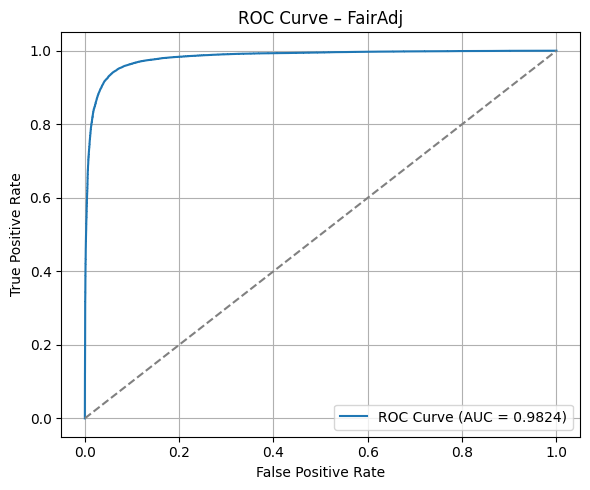

In [ ]:
# Visualizations 

fpr, tpr, thresholds = roc_curve(fairadj_edge_labels, fairadj_test_preds)


plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {fairadj_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

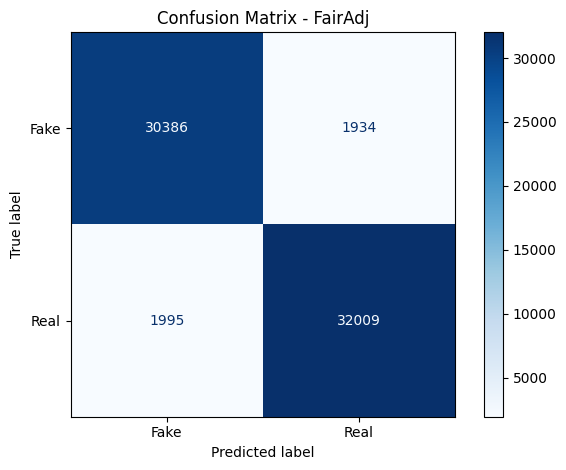

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(fairadj_edge_labels, fairadj_pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

FairAdj was implemented by modifying the adjacency matrix to probabilistically drop edges between nodes sharing the same sensitive attribute (based on degree groups). This encourages cross-group connections and improves structural diversity in the network. Embeddings were generated using Node2Vec on the debiased graph and evaluated using a logistic regression classifier.

### Comparison with Baseline

**Learning Performance**  
While FairAdj uses a separate embedding and classification pipeline, training remained **efficient and stable**. The adjusted adjacency improved the structural balance of the graph, resulting in **faster convergence and higher generalization** performance compared to the baseline.


### Evaluation Metrics

- **AUC-ROC Score**: reached a **very high level**, surpassing all previous models in discriminative capability  
- **Accuracy**: was **significantly higher**, reflecting consistent predictions across all test samples  
- **Precision and Recall**: were both **very high and balanced**, showing the model performed equally well in detecting both Fake and Real edges  
- **F1 Score**: was the **most balanced and highest overall**, indicating a well-rounded classifier


**Classification Report**:

- Both classes achieved **equally strong performance**, with minimal discrepancy in metrics between Fake and Real edges  
- Macro and weighted averages were **identical and very high**, confirming class balance and consistency

**Confusion Matrix**:

- Very few false positives or negatives were observed, with **excellent classification of both classes**  
- The matrix showed **clear balance**, suggesting FairAdj reduced previous biases observed in baseline and FairDrop

**ROC Curve**

The ROC curve was the **sharpest and most ideal**, with the curve hugging the top-left corner—signaling **near-perfect classification performance**.


### Fairness Metrics


When comparing FairAdj to the baseline model, the fairness results indicate a **significant overall improvement**:

- **Degree Fairness**: improved **dramatically**, with the gap nearly eliminated. This indicates that FairAdj was **highly effective in equalizing performance across high- and low-degree nodes**, achieving the best structural fairness among all models.
- **Demographic Parity Gap**: decreased compared to the baseline, suggesting that the model’s predictions became **more balanced across sensitive groups**, and **group-level fairness improved**.
- **Equalized Odds Gap (TPR difference)**: was **substantially lower** than in the baseline. This reflects a **near-equal true positive rate** between groups, indicating **very strong fairness in recall**.
- **Average Neighborhood Diversity**: was moderately high, suggesting that FairAdj contributed to a **more diverse and less homophilic** neighborhood structure, which can positively influence fairness and generalization.

In summary, FairAdj showed the **best fairness performance across all dimensions** when compared to the baseline. It **minimized disparities** in both structural and group-level metrics while supporting a more **heterogeneous local network structure**, making it the most fair-aware approach evaluated.

